In [1]:
# =========================
# CELL 1 – Imports & Paths
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.style.use("ggplot")
sns.set(font_scale=1.1)

DATA_DIR = Path("../data")
OUTPUT_PROVIDER_FILE = DATA_DIR / "provider_level_dataset.csv"


In [5]:
# =======================================
# CELL 2 – Load raw Kaggle train datasets
# =======================================

beneficiary = pd.read_csv(DATA_DIR / "/content/Train_Beneficiarydata-1542865627584.csv")
inpatient = pd.read_csv(DATA_DIR / "/content/Train_Inpatientdata-1542865627584.csv")
outpatient = pd.read_csv(DATA_DIR / "/content/Train_Outpatientdata-1542865627584.csv")

# This file name may be Train-*.csv or Train_Labels.csv; adjust as needed
labels = pd.read_csv(DATA_DIR / "/content/Train-1542865627584.xls")

print("Beneficiary shape:", beneficiary.shape)
print("Inpatient shape:", inpatient.shape)
print("Outpatient shape:", outpatient.shape)
print("Labels shape:", labels.shape)

beneficiary.head(), inpatient.head(), outpatient.head(), labels.head()


Beneficiary shape: (138556, 25)
Inpatient shape: (40474, 30)
Outpatient shape: (517737, 27)
Labels shape: (5410, 2)


(      BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
 0  BENE11001  1943-01-01  NaN       1     1                     0     39   
 1  BENE11002  1936-09-01  NaN       2     1                     0     39   
 2  BENE11003  1936-08-01  NaN       1     1                     0     52   
 3  BENE11004  1922-07-01  NaN       1     1                     0     39   
 4  BENE11005  1935-09-01  NaN       1     1                     0     24   
 
    County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
 0     230                   12                   12  ...   
 1     280                   12                   12  ...   
 2     590                   12                   12  ...   
 3     270                   12                   12  ...   
 4     680                   12                   12  ...   
 
    ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
 0                       1                     1                          1   
 1        

In [6]:
# ==================================
# CELL 3 – Basic data understanding
# ==================================

def quick_info(df, name):
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print(df.dtypes.head())
    print("Missing values (top 10):")
    print(df.isna().sum().sort_values(ascending=False).head(10))

quick_info(beneficiary, "Beneficiary")
quick_info(inpatient, "Inpatient")
quick_info(outpatient, "Outpatient")
quick_info(labels, "Labels")



=== Beneficiary ===
Shape: (138556, 25)
BeneID    object
DOB       object
DOD       object
Gender     int64
Race       int64
dtype: object
Missing values (top 10):
DOD                      137135
BeneID                        0
DOB                           0
Gender                        0
Race                          0
RenalDiseaseIndicator         0
State                         0
County                        0
NoOfMonths_PartACov           0
NoOfMonths_PartBCov           0
dtype: int64

=== Inpatient ===
Shape: (40474, 30)
BeneID          object
ClaimID         object
ClaimStartDt    object
ClaimEndDt      object
Provider        object
dtype: object
Missing values (top 10):
ClmProcedureCode_6     40474
ClmProcedureCode_5     40465
ClmProcedureCode_4     40358
ClmProcedureCode_3     39509
ClmDiagnosisCode_10    36547
OtherPhysician         35784
ClmProcedureCode_2     35020
ClmProcedureCode_1     17326
OperatingPhysician     16644
ClmDiagnosisCode_9     13497
dtype: int64

=== Ou

In [7]:
# ===============================================
# CELL 4 – Standardize fraud label to numeric y
# ===============================================

# Assume columns: Provider, PotentialFraud in labels (Yes/No)
labels.rename(columns=str.strip, inplace=True)

if "PotentialFraud" in labels.columns:
    labels["is_fraud"] = (labels["PotentialFraud"].astype(str).str.upper() == "YES").astype(int)
elif "Potential_Fraud" in labels.columns:
    labels["is_fraud"] = (labels["Potential_Fraud"].astype(str).str.upper() == "YES").astype(int)
else:
    raise ValueError("Could not find PotentialFraud column in labels file.")

labels["is_fraud"].value_counts(normalize=True)


,proportion
is_fraud,
0,0.90647
1,0.09353


In [8]:
# ============================================
# CELL 5 – Merge inpatient & outpatient claims
# ============================================

# Add a flag to distinguish inpatient vs outpatient
inpatient["ClaimType"] = "Inpatient"
outpatient["ClaimType"] = "Outpatient"

# Common columns across both claim tables
common_cols = list(set(inpatient.columns).intersection(set(outpatient.columns)))

inpatient_common = inpatient[common_cols].copy()
outpatient_common = outpatient[common_cols].copy()

claims = pd.concat([inpatient_common, outpatient_common], ignore_index=True)
print("Merged claim-level dataset shape:", claims.shape)
claims.head()


Merged claim-level dataset shape: (558211, 28)


,ClmDiagnosisCode_2,ClmProcedureCode_4,Provider,ClmDiagnosisCode_7,ClmDiagnosisCode_6,ClmProcedureCode_2,ClmDiagnosisCode_3,OperatingPhysician,ClaimType,ClmDiagnosisCode_1,...,ClmDiagnosisCode_10,InscClaimAmtReimbursed,ClmDiagnosisCode_4,ClmProcedureCode_3,ClaimStartDt,ClmProcedureCode_1,BeneID,AttendingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_9
0,4019,NaN,PRV55912,2724,71590,NaN,5853,NaN,Inpatient,1970,...,NaN,26000,7843,NaN,2009-04-12,NaN,BENE11001,PHY390922,1068.0,5849
1,2948,NaN,PRV55907,NaN,NaN,NaN,56400,PHY318495,Inpatient,6186,...,NaN,5000,NaN,NaN,2009-08-31,7092.0,BENE11001,PHY318495,1068.0,NaN
2,30390,NaN,PRV56046,NaN,32723,NaN,71690,NaN,Inpatient,29623,...,NaN,5000,34590,NaN,2009-09-17,NaN,BENE11001,PHY372395,1068.0,NaN
3,2762,NaN,PRV52405,25062,4254,NaN,7843,PHY392961,Inpatient,43491,...,NaN,5000,32723,NaN,2009-02-14,331.0,BENE11011,PHY369659,1068.0,4019
4,3051,NaN,PRV56614,5119,486,NaN,34400,PHY398258,Inpatient,042,...,NaN,10000,5856,NaN,2009-08-13,3893.0,BENE11014,PHY379376,1068.0,20300


In [9]:
# ====================================
# CELL 6 – Merge claims with patients
# ====================================

# We'll join on BeneID (patient identifier)
if "BeneID" not in claims.columns or "BeneID" not in beneficiary.columns:
    raise ValueError("BeneID not found in claims / beneficiary; adjust join key names.")

claims = claims.merge(beneficiary, on="BeneID", how="left", suffixes=("", "_bene"))
print("Claims + Beneficiary shape:", claims.shape)
claims.head()


Claims + Beneficiary shape: (558211, 52)


,ClmDiagnosisCode_2,ClmProcedureCode_4,Provider,ClmDiagnosisCode_7,ClmDiagnosisCode_6,ClmProcedureCode_2,ClmDiagnosisCode_3,OperatingPhysician,ClaimType,ClmDiagnosisCode_1,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,4019,NaN,PRV55912,2724,71590,NaN,5853,NaN,Inpatient,1970,...,1,1,1,2,1,1,36000,3204,60,70
1,2948,NaN,PRV55907,NaN,NaN,NaN,56400,PHY318495,Inpatient,6186,...,1,1,1,2,1,1,36000,3204,60,70
2,30390,NaN,PRV56046,NaN,32723,NaN,71690,NaN,Inpatient,29623,...,1,1,1,2,1,1,36000,3204,60,70
3,2762,NaN,PRV52405,25062,4254,NaN,7843,PHY392961,Inpatient,43491,...,1,1,2,2,1,1,5000,1068,250,320
4,3051,NaN,PRV56614,5119,486,NaN,34400,PHY398258,Inpatient,042,...,1,2,1,2,2,2,21260,2136,120,100


In [10]:
# ==================================
# CELL 7 – Merge with provider label
# ==================================

if "Provider" not in claims.columns or "Provider" not in labels.columns:
    raise ValueError("Provider column not found – check input file column names.")

claims = claims.merge(labels[["Provider", "is_fraud"]], on="Provider", how="left")
claims["is_fraud"].value_counts(dropna=False)


,count
is_fraud,
0,345415
1,212796


In [11]:
# ======================================
# CELL 8 – Parse date columns & durations
# ======================================

date_cols = [c for c in claims.columns if "Dt" in c or "Date" in c]

for col in date_cols:
    try:
        claims[col] = pd.to_datetime(claims[col])
    except Exception:
        pass  # some may already be datetime or non-date strings

# Example: Claim duration = ClaimEndDt - ClaimStartDt
if {"ClaimStartDt", "ClaimEndDt"}.issubset(claims.columns):
    claims["ClaimDuration_days"] = (claims["ClaimEndDt"] - claims["ClaimStartDt"]).dt.days
else:
    claims["ClaimDuration_days"] = np.nan

# Example: Treatment duration = DischargeDt - AdmissionDt (inpatient only)
if {"AdmissionDt", "DischargeDt"}.issubset(claims.columns):
    claims["TreatmentDuration_days"] = (claims["DischargeDt"] - claims["AdmissionDt"]).dt.days
else:
    claims["TreatmentDuration_days"] = np.nan

claims[["ClaimDuration_days", "TreatmentDuration_days"]].describe()


,ClaimDuration_days,TreatmentDuration_days
count,558211.000000,0.0
mean,1.727940,NaN
std,4.904984,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN
max,36.000000,NaN


In [12]:
# ====================================
# CELL 9 – Simple missing value summary
# ====================================

missing = claims.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(claims) * 100).round(2)

missing_df = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
missing_df.head(20)


,missing_count,missing_pct
ClmProcedureCode_6,558211,100.00
TreatmentDuration_days,558211,100.00
ClmProcedureCode_5,558202,100.00
ClmProcedureCode_4,558093,99.98
ClmProcedureCode_3,557242,99.83
DOD,554080,99.26
ClmDiagnosisCode_10,553201,99.10
ClmProcedureCode_2,552721,99.02
ClmProcedureCode_1,534901,95.82
ClmDiagnosisCode_9,516396,92.51


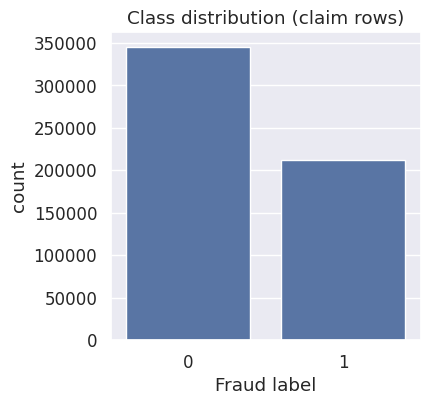

Provider-level class distribution:
 is_fraud
0    0.90647
1    0.09353
Name: proportion, dtype: float64


In [13]:
# ===================================
# CELL 10 – Target class distribution
# ===================================

plt.figure(figsize=(4, 4))
sns.countplot(x="is_fraud", data=claims)
plt.title("Class distribution (claim rows)")
plt.xlabel("Fraud label")
plt.show()

fraud_by_provider = labels["is_fraud"].value_counts(normalize=True)
print("Provider-level class distribution:\n", fraud_by_provider)


In [14]:
# ===========================================================
# CELL 11 – Example EDA: claim amount (InscClaimAmtReimbursed)
# ===========================================================

amt_col_candidates = [c for c in claims.columns if "InscClaimAmtReimbursed" in c or "ClaimAmt" in c]
amt_col_candidates


['InscClaimAmtReimbursed']

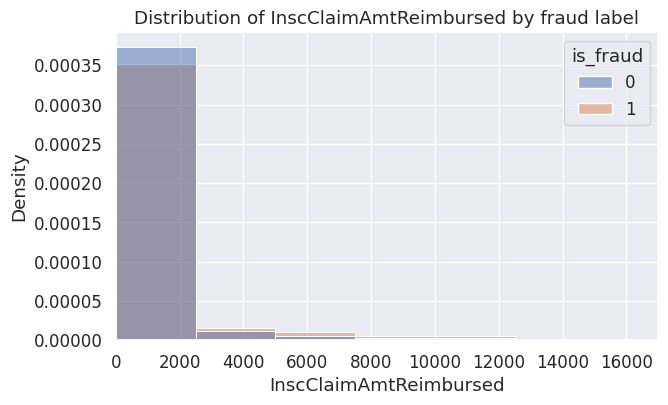

In [15]:
# If we have an amount column, plot distributions
if amt_col_candidates:
    amt_col = amt_col_candidates[0]
    plt.figure(figsize=(7, 4))
    sns.histplot(data=claims, x=amt_col, hue="is_fraud", bins=50, stat="density", common_norm=False)
    plt.xlim(0, claims[amt_col].quantile(0.99))  # clip extreme outliers just for visualization
    plt.title(f"Distribution of {amt_col} by fraud label")
    plt.show()


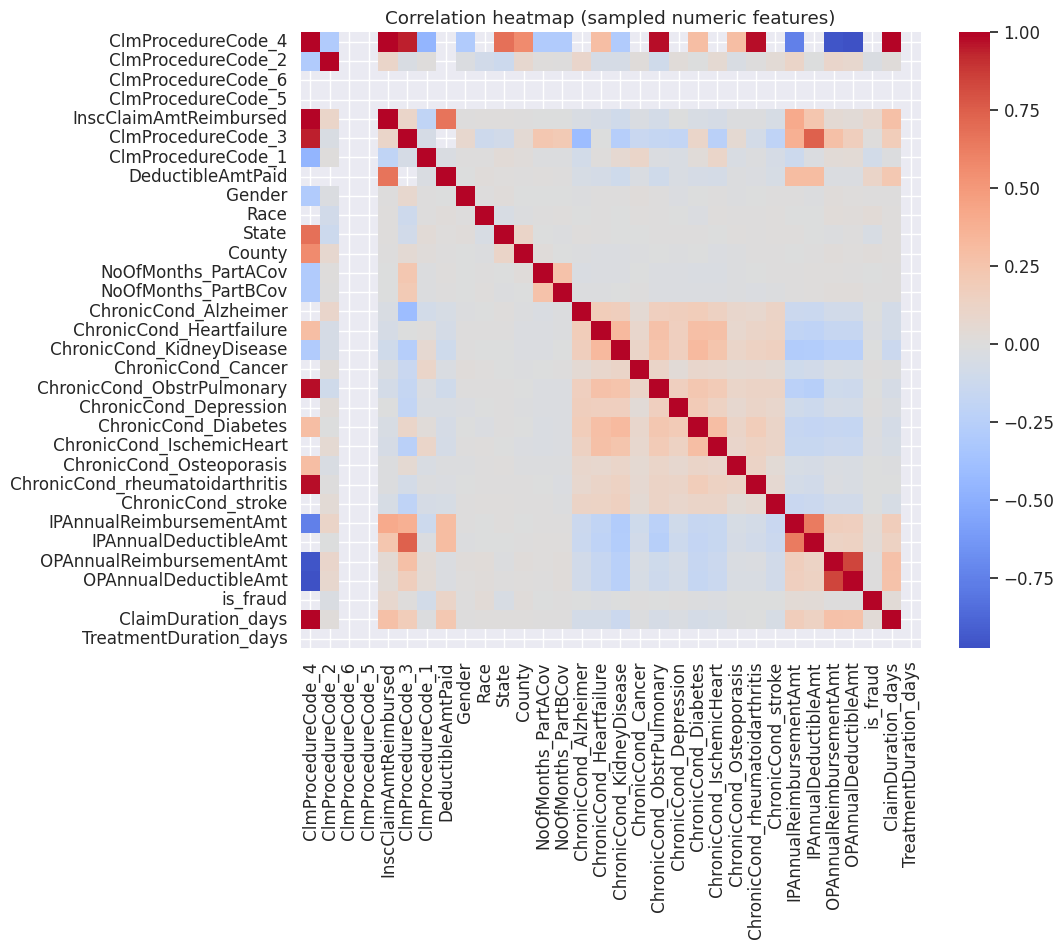

In [16]:
# ==============================================
# CELL 12 – Example correlation heatmap (numeric)
# ==============================================

numeric_cols = claims.select_dtypes(include=[np.number]).columns
sample_numeric = claims[numeric_cols].sample(min(20000, len(claims)), random_state=42)  # to speed up

corr = sample_numeric.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (sampled numeric features)")
plt.show()


In [17]:
# =============================================================
# CELL 13 – Aggregate claim-level data into provider-level data
# =============================================================

# Some helper booleans
claims["is_inpatient"] = (claims["ClaimType"] == "Inpatient").astype(int)
claims["is_outpatient"] = (claims["ClaimType"] == "Outpatient").astype(int)

# Identify key numeric columns we want to aggregate
agg_dict = {}

if amt_col_candidates:
    amt_col = amt_col_candidates[0]
    agg_dict[amt_col] = ["sum", "mean", "max"]

agg_dict.update({
    "ClaimDuration_days": ["mean", "max"],
    "TreatmentDuration_days": ["mean", "max"],
    "is_inpatient": ["sum"],
    "is_outpatient": ["sum"]
})

# Add counts of unique claims & beneficiaries
agg_dict["BeneID"] = ["nunique"]
agg_dict["ClaimID"] = ["nunique"] if "ClaimID" in claims.columns else ["count"]

provider_agg = claims.groupby("Provider").agg(agg_dict)

# Flatten multiindex columns
provider_agg.columns = ["_".join([c for c in col if c]) for col in provider_agg.columns.values]

provider_agg.head()


,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_max,ClaimDuration_days_mean,ClaimDuration_days_max,TreatmentDuration_days_mean,TreatmentDuration_days_max,is_inpatient_sum,is_outpatient_sum,BeneID_nunique,ClaimID_nunique
Provider,,,,,,,,,,,
PRV51001,104640,4185.600000,42000,1.440000,14,NaN,NaN,5,20,24,25
PRV51003,605670,4588.409091,57000,3.674242,27,NaN,NaN,62,70,117,132
PRV51004,52170,350.134228,3300,1.429530,20,NaN,NaN,0,149,138,149
PRV51005,280910,241.124464,4080,1.088412,20,NaN,NaN,0,1165,495,1165
PRV51007,33710,468.194444,10000,0.958333,20,NaN,NaN,3,69,58,72


In [18]:
# ===================================================
# CELL 14 – Additional provider-level ratio features
# ===================================================

df = provider_agg.copy()

# Total claims per provider
if "ClaimID_nunique" in df.columns:
    df["total_claims"] = df["ClaimID_nunique"]
else:
    # fall back to count
    df["total_claims"] = df.filter(like="ClaimID_").iloc[:, 0]

# Total beneficiaries per provider
if "BeneID_nunique" in df.columns:
    df["unique_beneficiaries"] = df["BeneID_nunique"]

# Ratios: inpatient vs outpatient mix
if "is_inpatient_sum" in df.columns and "is_outpatient_sum" in df.columns:
    df["inpatient_share"] = df["is_inpatient_sum"] / df["total_claims"].replace(0, np.nan)
    df["outpatient_share"] = df["is_outpatient_sum"] / df["total_claims"].replace(0, np.nan)

# Average claims per beneficiary
df["claims_per_beneficiary"] = df["total_claims"] / df["unique_beneficiaries"].replace(0, np.nan)

df.head()


,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_max,ClaimDuration_days_mean,ClaimDuration_days_max,TreatmentDuration_days_mean,TreatmentDuration_days_max,is_inpatient_sum,is_outpatient_sum,BeneID_nunique,ClaimID_nunique,total_claims,unique_beneficiaries,inpatient_share,outpatient_share,claims_per_beneficiary
Provider,,,,,,,,,,,,,,,,
PRV51001,104640,4185.600000,42000,1.440000,14,NaN,NaN,5,20,24,25,25,24,0.200000,0.800000,1.041667
PRV51003,605670,4588.409091,57000,3.674242,27,NaN,NaN,62,70,117,132,132,117,0.469697,0.530303,1.128205
PRV51004,52170,350.134228,3300,1.429530,20,NaN,NaN,0,149,138,149,149,138,0.000000,1.000000,1.079710
PRV51005,280910,241.124464,4080,1.088412,20,NaN,NaN,0,1165,495,1165,1165,495,0.000000,1.000000,2.353535
PRV51007,33710,468.194444,10000,0.958333,20,NaN,NaN,3,69,58,72,72,58,0.041667,0.958333,1.241379


In [19]:
# =====================================================
# CELL 15 – Add fraud label back at provider granularity
# =====================================================

provider_df = df.merge(labels[["Provider", "is_fraud"]], left_index=True, right_on="Provider", how="left")
provider_df.set_index("Provider", inplace=True)

print(provider_df["is_fraud"].value_counts(dropna=False))
provider_df.head()


is_fraud
0    4904
1     506
Name: count, dtype: int64


,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_max,ClaimDuration_days_mean,ClaimDuration_days_max,TreatmentDuration_days_mean,TreatmentDuration_days_max,is_inpatient_sum,is_outpatient_sum,BeneID_nunique,ClaimID_nunique,total_claims,unique_beneficiaries,inpatient_share,outpatient_share,claims_per_beneficiary,is_fraud
Provider,,,,,,,,,,,,,,,,,
PRV51001,104640,4185.600000,42000,1.440000,14,NaN,NaN,5,20,24,25,25,24,0.200000,0.800000,1.041667,0
PRV51003,605670,4588.409091,57000,3.674242,27,NaN,NaN,62,70,117,132,132,117,0.469697,0.530303,1.128205,1
PRV51004,52170,350.134228,3300,1.429530,20,NaN,NaN,0,149,138,149,149,138,0.000000,1.000000,1.079710,0
PRV51005,280910,241.124464,4080,1.088412,20,NaN,NaN,0,1165,495,1165,1165,495,0.000000,1.000000,2.353535,1
PRV51007,33710,468.194444,10000,0.958333,20,NaN,NaN,3,69,58,72,72,58,0.041667,0.958333,1.241379,0


In [21]:
# ============================================
# CELL 16 – Final cleaning & export for models
# ============================================

from pathlib import Path

# Make sure data dir exists (assuming notebook is in /notebooks and data is in ../data)
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_PROVIDER_FILE = DATA_DIR / "provider_level_dataset.csv"

# Drop any columns that are almost all NaN
null_pct = provider_df.isna().mean()
cols_to_drop = null_pct[null_pct > 0.9].index.tolist()
provider_df = provider_df.drop(columns=cols_to_drop)

# Fill remaining numeric NaNs with median – avoid chained assignment
for col in provider_df.columns:
    if provider_df[col].dtype != "object":
        median_val = provider_df[col].median()
        provider_df[col] = provider_df[col].fillna(median_val)

provider_df.to_csv(OUTPUT_PROVIDER_FILE, index=False)
print("Saved provider-level dataset to:", OUTPUT_PROVIDER_FILE)
provider_df.head()


Saved provider-level dataset to: ../data/provider_level_dataset.csv


,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_max,ClaimDuration_days_mean,ClaimDuration_days_max,is_inpatient_sum,is_outpatient_sum,BeneID_nunique,ClaimID_nunique,total_claims,unique_beneficiaries,inpatient_share,outpatient_share,claims_per_beneficiary,is_fraud
Provider,,,,,,,,,,,,,,,
PRV51001,104640,4185.600000,42000,1.440000,14,5,20,24,25,25,24,0.200000,0.800000,1.041667,0
PRV51003,605670,4588.409091,57000,3.674242,27,62,70,117,132,132,117,0.469697,0.530303,1.128205,1
PRV51004,52170,350.134228,3300,1.429530,20,0,149,138,149,149,138,0.000000,1.000000,1.079710,0
PRV51005,280910,241.124464,4080,1.088412,20,0,1165,495,1165,1165,495,0.000000,1.000000,2.353535,1
PRV51007,33710,468.194444,10000,0.958333,20,3,69,58,72,72,58,0.041667,0.958333,1.241379,0


In [22]:
from pathlib import Path

# Create a data folder inside /content
DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(exist_ok=True)

OUTPUT_PROVIDER_FILE = DATA_DIR / "provider_level_dataset.csv"

# Fill NaN safely (no inplace warning)
for col in provider_df.columns:
    if provider_df[col].dtype != "object":
        median_val = provider_df[col].median()
        provider_df[col] = provider_df[col].fillna(median_val)

# Save provider-level dataset
provider_df.to_csv(OUTPUT_PROVIDER_FILE, index=False)

print("SAVED TO:", OUTPUT_PROVIDER_FILE)


SAVED TO: /content/data/provider_level_dataset.csv
